<a href="https://colab.research.google.com/github/frankl1/Introduction-to-Tensorflow-for-Deep-Learning/blob/master/Time_Windows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x 
except:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


TensorFlow 2.x selected.


In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

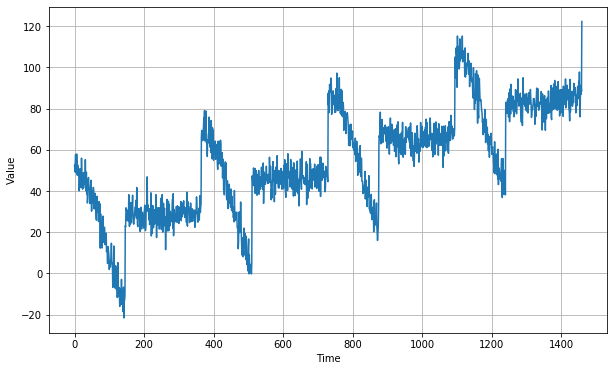

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
window_size = 30
train_set = window_dataset(x_train, window_size)
val_set = window_dataset(x_valid, window_size)

# Linear model

In [7]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[window_size])    
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, validation_data=val_set, epochs=500)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================] - 1s 30ms/step - loss: 110.0710 - mae: 111.7079 - val_loss: 68.8032 - val_mae: 69.2154
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 16.2024 - mae: 16.8313 - val_loss: 17.3176 - val_mae: 17.8390
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 10.5869 - mae: 11.1007 - val_loss: 10.3742 - val_mae: 10.7255
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 9.6080 - mae: 10.1342 - val_loss: 9.6221 - val_mae: 10.1280
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 9.3489 - mae: 9.7909 - val_loss: 9.0160 

In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  return model.predict(ds)

In [0]:
linear_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)
linear_forecast = linear_forecast[:, 0]

In [0]:
def plot_forecast(truth, forecast, times):
  mae = tf.keras.metrics.mean_absolute_error(truth, forecast).numpy()
  plt.plot(times, truth, label="Ground truth")
  plt.plot(times, forecast, label="Forecast")
  plt.title(f"MAE={mae}")
  plt.legend()

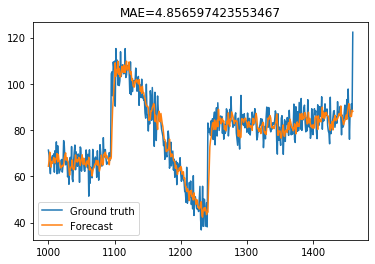

In [11]:
plot_forecast(x_valid, linear_forecast, time_valid)

# Dense model

In [12]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, validation_data=val_set, epochs=500)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================] - 1s 24ms/step - loss: 28.6957 - mae: 29.5966 - val_loss: 16.7593 - val_mae: 17.2011
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 9.0997 - mae: 9.6387 - val_loss: 9.0807 - val_mae: 9.5861
Epoch 3/500
31/31 [==============================] - 0s 11ms/step - loss: 8.5278 - mae: 8.7975 - val_loss: 7.7719 - va

In [0]:
linear_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)
linear_forecast = linear_forecast[:, 0]

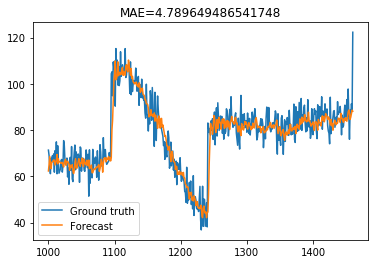

In [14]:
plot_forecast(x_valid, linear_forecast, time_valid)